In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy
import torch

%matplotlib inline
numpy.float=float
numpy.bool=bool
numpy.int=int

In [3]:
import hddm
import kabuki

### Base model & convergence test

In [3]:
data = hddm.load_csv('behav_beta_cleaned.csv')

In [4]:
data = data.drop(columns="Unnamed: 0")
data.head()

,subj_idx,SESSION,RUN,TRIAL,X73KID,ISOLD,ISCORRECT,rt,CHANGEMIND,MEMORYRECENT,...,TOTAL2,response,MISSINGDATA,trial_full,is_shared1000,is_special100,shared1000_repNum,presentation_type,MTL_ROI_Beta,result
0,1,1,1,1,46003,0,1,0.803530,0,NaN,...,0,0,0,1,1,0,1,new,0.134300,CR
1,1,1,1,2,61883,0,1,0.972261,0,NaN,...,0,0,0,2,0,0,0,unknown,0.033132,CR
2,1,1,1,3,829,0,1,0.742351,0,NaN,...,0,0,0,3,0,0,0,unknown,0.248891,CR
3,1,1,1,4,67574,0,1,0.747518,0,NaN,...,0,0,0,4,0,0,0,unknown,0.071685,CR
4,1,1,1,5,16021,0,1,0.547423,0,NaN,...,0,0,0,5,0,0,0,unknown,0.097249,CR


In [5]:
data = hddm.utils.flip_errors(data)
data.head(10)

,subj_idx,SESSION,RUN,TRIAL,X73KID,ISOLD,ISCORRECT,rt,CHANGEMIND,MEMORYRECENT,...,TOTAL2,response,MISSINGDATA,trial_full,is_shared1000,is_special100,shared1000_repNum,presentation_type,MTL_ROI_Beta,result
0,1,1,1,1,46003,0,1,-0.803530,0,NaN,...,0,0,0,1,1,0,1,new,0.134300,CR
1,1,1,1,2,61883,0,1,-0.972261,0,NaN,...,0,0,0,2,0,0,0,unknown,0.033132,CR
2,1,1,1,3,829,0,1,-0.742351,0,NaN,...,0,0,0,3,0,0,0,unknown,0.248891,CR
3,1,1,1,4,67574,0,1,-0.747518,0,NaN,...,0,0,0,4,0,0,0,unknown,0.071685,CR
4,1,1,1,5,16021,0,1,-0.547423,0,NaN,...,0,0,0,5,0,0,0,unknown,0.097249,CR
5,1,1,1,6,40423,0,1,-0.510572,0,NaN,...,0,0,0,6,0,0,0,unknown,0.266320,CR
6,1,1,1,7,51518,0,1,-0.524695,0,NaN,...,0,0,0,7,0,0,0,unknown,0.499896,CR
7,1,1,1,8,62326,0,1,-0.622750,0,NaN,...,0,0,0,8,0,0,0,unknown,0.149043,CR
8,1,1,1,9,50611,0,1,-0.577387,0,NaN,...,0,0,0,9,0,0,0,unknown,-0.169051,CR
9,1,1,1,10,55066,0,1,-0.522792,0,NaN,...,0,0,0,10,0,0,0,unknown,-0.102734,CR


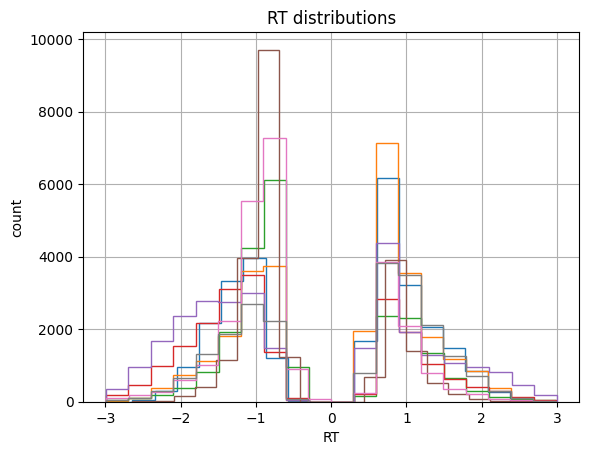

In [6]:
#check RT distributions

fig = plt.figure()
ax = fig.add_subplot(111, xlabel='RT', ylabel='count', title='RT distributions')
#ax.set_xlim([-1, 1])
#ax.set_ylim([0, 150])
for i, subj_data in data.groupby('subj_idx'):
    subj_data.rt.hist(bins=20, histtype='step', ax=ax)

In [10]:
m = hddm.HDDM(data, bias=True, include=('v','a','z','t'), p_outlier=.05)
m.find_starting_values()
m.sample(2000, burn=500)

No model attribute --> setting up standard HDDM
Set model to ddm


/srv/conda/envs/notebook/lib/python3.8/site-packages/scipy/optimize/_optimize.py:2417: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 [-----------------100%-----------------] 2001 of 2000 complete in 2248.9 sec

In [11]:
stats = m.gen_stats()
stats[stats.index.isin(['a', 'a_std', 'a_subj.1', 'a_subj.2'])]

,mean,std,2.5q,25q,50q,75q,97.5q,mc err
a,1.690117,0.120245,1.472655,1.614247,1.683403,1.756237,1.961417,0.003524
a_std,0.323191,0.118962,0.182561,0.242374,0.2993,0.369126,0.609831,0.005228
a_subj.1,1.73867,0.004984,1.729535,1.735201,1.738637,1.742056,1.748567,0.000149
a_subj.2,1.590946,0.004594,1.582011,1.587751,1.590921,1.59404,1.600136,0.000136


Plotting a
Plotting v
Plotting t
Plotting z


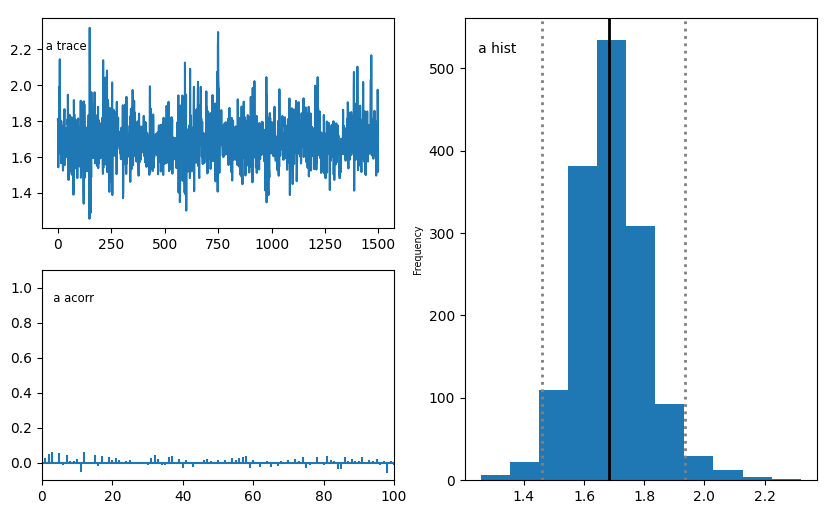

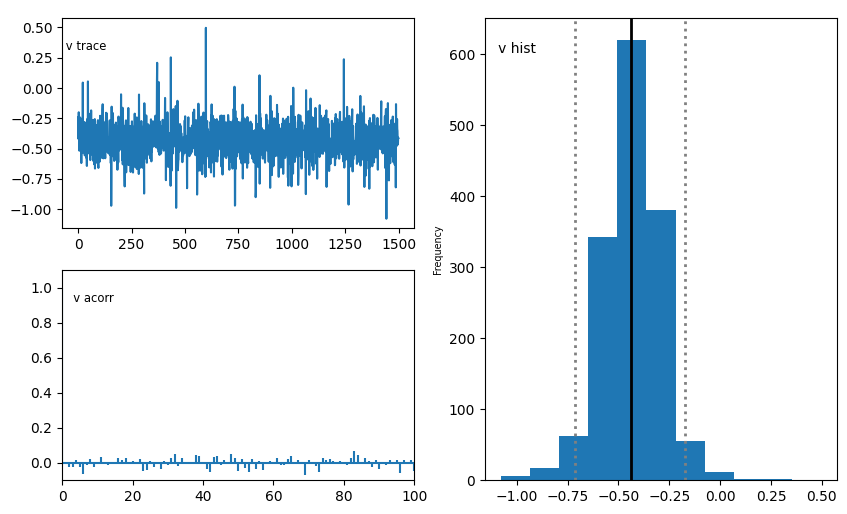

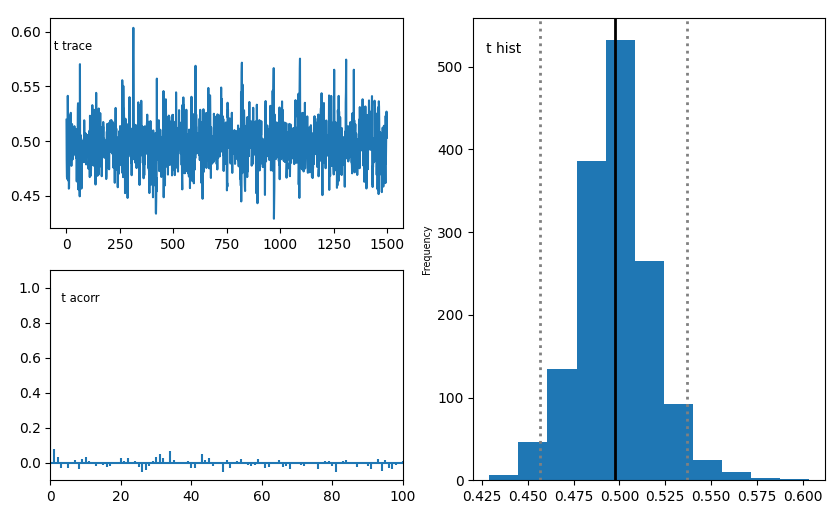

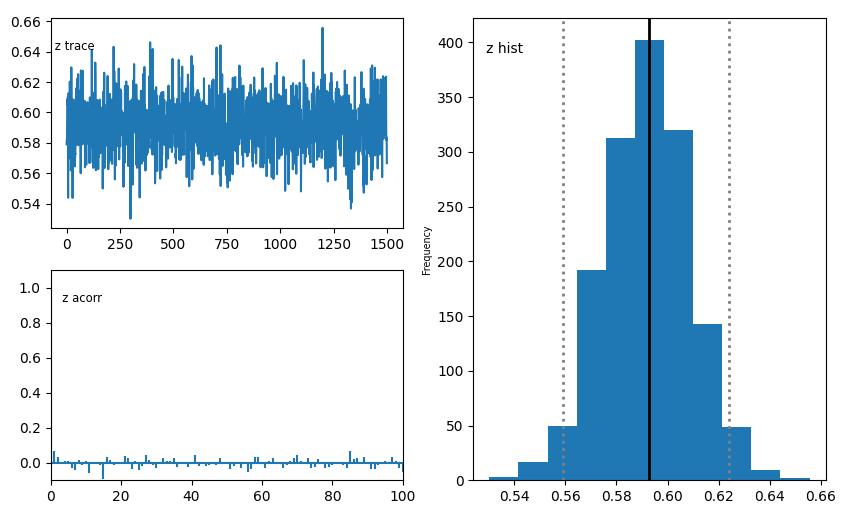

In [12]:
m.plot_posteriors(['a', 't', 'v', 'z'])


In [13]:
#Gelman-Rubin statistic
#formal test for convergence; compares intra-chain variance to intra-chain variance of different runs of same model
# values should be close to 1, no larger than 1.02

models = []
for i in range(5):
    m = hddm.HDDM(data,bias=True, include=('v','a','z','t'), p_outlier=.05)
    m.find_starting_values()
    m.sample(2000, burn=500)
    models.append(m)

hddm.analyze.gelman_rubin(models)

No model attribute --> setting up standard HDDM
Set model to ddm


/srv/conda/envs/notebook/lib/python3.8/site-packages/scipy/optimize/_optimize.py:2417: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 [-----------------100%-----------------] 2001 of 2000 complete in 2230.0 secNo model attribute --> setting up standard HDDM
Set model to ddm


/srv/conda/envs/notebook/lib/python3.8/site-packages/scipy/optimize/_optimize.py:2417: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 [-----------------100%-----------------] 2001 of 2000 complete in 2225.3 secNo model attribute --> setting up standard HDDM
Set model to ddm


/srv/conda/envs/notebook/lib/python3.8/site-packages/scipy/optimize/_optimize.py:2417: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 [-----------------100%-----------------] 2001 of 2000 complete in 2235.0 secNo model attribute --> setting up standard HDDM
Set model to ddm


/srv/conda/envs/notebook/lib/python3.8/site-packages/scipy/optimize/_optimize.py:2417: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 [-----------------100%-----------------] 2001 of 2000 complete in 2245.0 secNo model attribute --> setting up standard HDDM
Set model to ddm


/srv/conda/envs/notebook/lib/python3.8/site-packages/scipy/optimize/_optimize.py:2417: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 [-----------------100%-----------------] 2001 of 2000 complete in 2245.1 sec

{'a': 1.000204560412946,
 'a_std': 1.0018842906484204,
 'a_subj.1': 1.000305333151521,
 'a_subj.2': 1.0001178880419193,
 'a_subj.3': 1.0000697629674147,
 'a_subj.4': 1.0013011511966232,
 'a_subj.5': 1.0010092460467426,
 'a_subj.6': 1.0007167392455079,
 'a_subj.7': 1.000965592414526,
 'a_subj.8': 1.000697387535265,
 'v': 1.0000239804451287,
 'v_std': 1.001188249088027,
 'v_subj.1': 1.0002878042122025,
 'v_subj.2': 0.9999187841673323,
 'v_subj.3': 0.9999897325684061,
 'v_subj.4': 1.0013367515915546,
 'v_subj.5': 1.0017420762900124,
 'v_subj.6': 0.9997827439065743,
 'v_subj.7': 1.0000903662522675,
 'v_subj.8': 1.001292631680644,
 't': 0.9997629413825837,
 't_std': 1.0001812493659323,
 't_subj.1': 0.999788216444555,
 't_subj.2': 0.9999634456398824,
 't_subj.3': 1.0009804502636057,
 't_subj.4': 1.0004031719344266,
 't_subj.5': 1.0021231331820868,
 't_subj.6': 1.0014919791057266,
 't_subj.7': 1.000602400949678,
 't_subj.8': 1.0010285506639207,
 'z_trans': 1.0000390017712337,
 'z_std': 0.9999

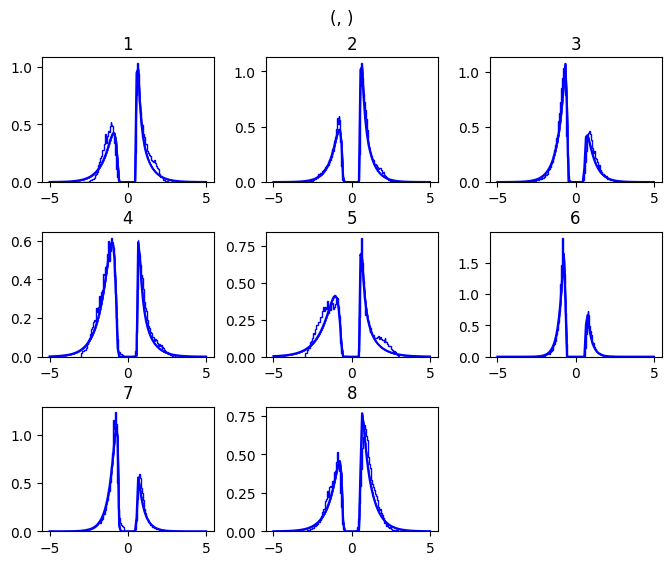

In [15]:
m.plot_posterior_predictive()

In [7]:
m = hddm.HDDM(data[data.is_shared1000 == 1], bias=True, include=('v','a','z','t'), p_outlier=.05)
m.find_starting_values()
m.sample(2000, burn=500)

No model attribute --> setting up standard HDDM
Set model to ddm


/srv/conda/envs/notebook/lib/python3.8/site-packages/scipy/optimize/_optimize.py:2417: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 [-----------------100%-----------------] 2000 of 2000 complete in 255.6 sec

In [8]:
stats = m.gen_stats()
stats[stats.index.isin(['a', 'a_std', 'a_subj.1', 'a_subj.2'])]

,mean,std,2.5q,25q,50q,75q,97.5q,mc err
a,1.693703,0.127691,1.466559,1.615199,1.68382,1.760713,1.972561,0.003806
a_std,0.336672,0.139125,0.177523,0.246783,0.300614,0.388403,0.68525,0.006453
a_subj.1,1.75288,0.016256,1.721701,1.741843,1.752676,1.763363,1.784534,0.000589
a_subj.2,1.608024,0.015775,1.576133,1.597214,1.60701,1.619119,1.638929,0.000557


Plotting a
Plotting v
Plotting t
Plotting z


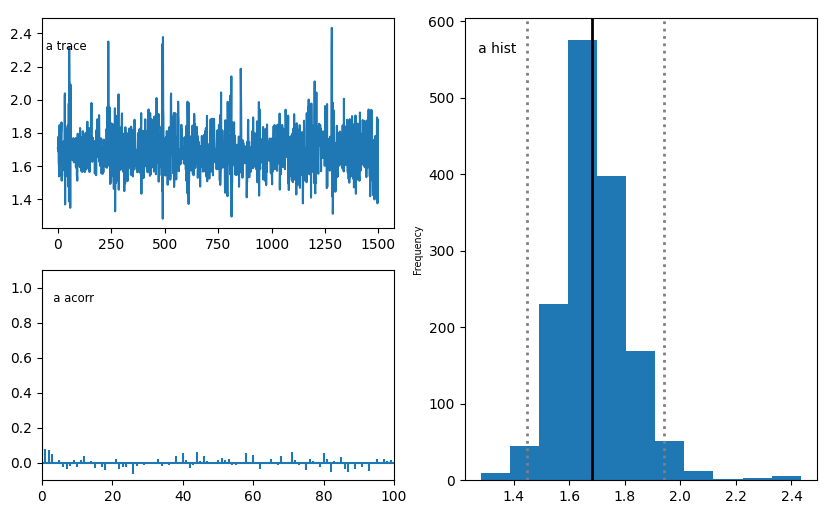

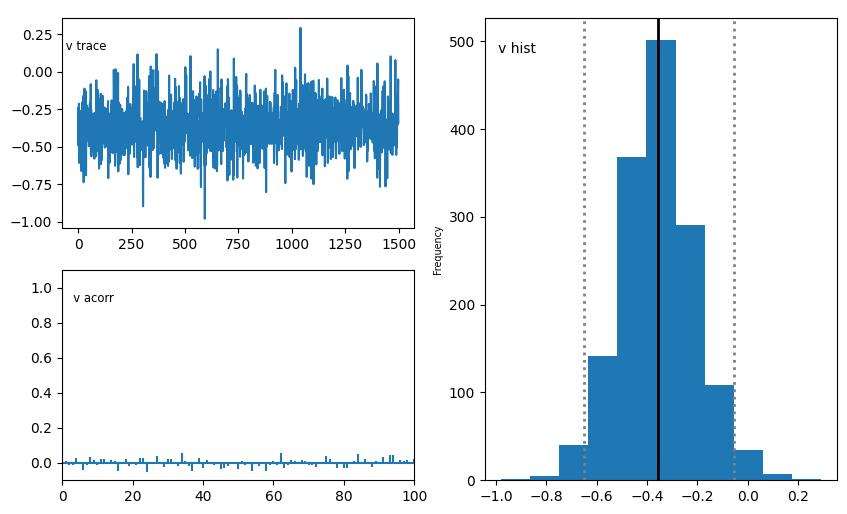

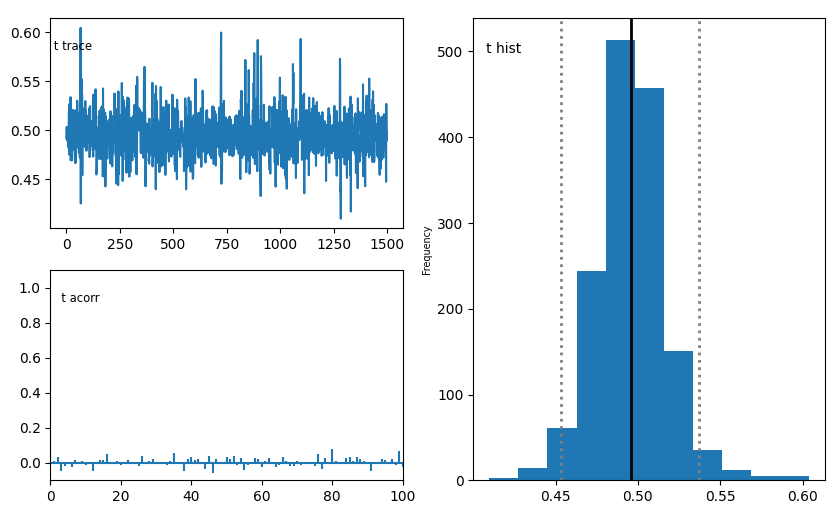

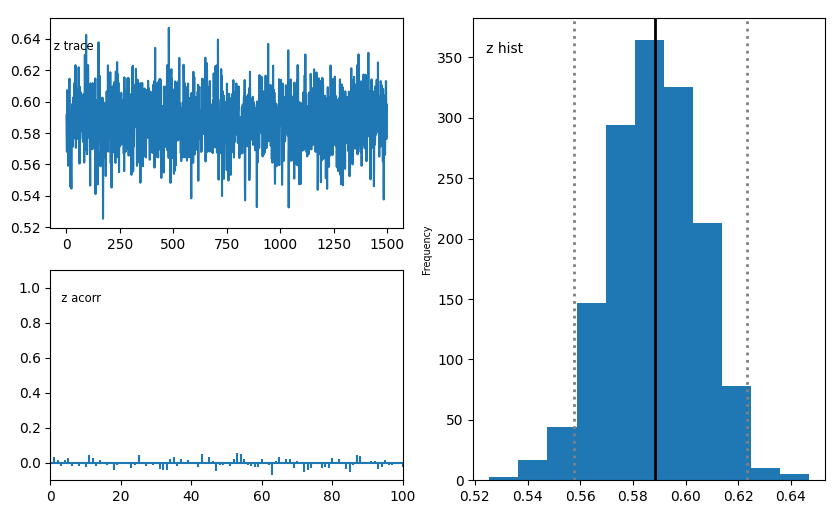

In [9]:
m.plot_posteriors(['a', 't', 'v', 'z'])

In [ ]:
##########################

### Data with all subregion data + filtering according to needs

In [4]:
data_all = hddm.load_csv('behav_ALLMTL-beta_cleaned.csv')

In [5]:
data_all

,Unnamed: 0,subj_idx,SESSION,RUN,TRIAL,X73KID,ISOLD,ISCORRECT,rt,CHANGEMIND,...,Beta_BA35,Beta_BA36,Beta_SUB,Beta_CA1,Beta_CA2,Beta_CA3,Beta_DG,Beta_PHC,Beta_HT,result
0,1,1,1,1,1,46003,0,1,0.803530,0,...,0.553485,0.342081,-0.215381,0.021860,0.038627,-0.098542,0.205302,0.813741,-0.115127,CR
1,2,1,1,1,2,61883,0,1,0.972261,0,...,0.471286,0.519131,-0.111705,-0.476570,-0.430588,0.035729,-0.041759,0.808235,-0.319157,CR
2,3,1,1,1,3,829,0,1,0.742351,0,...,0.642047,0.597336,-0.004848,-0.064477,0.146863,0.058229,0.280958,1.317345,-0.269116,CR
3,4,1,1,1,4,67574,0,1,0.747518,0,...,0.346708,0.196391,0.082410,0.181488,0.183922,0.082604,0.093819,0.299170,-0.116787,CR
4,5,1,1,1,5,16021,0,1,0.547423,0,...,0.351107,0.479366,-0.237771,-0.134187,-0.004902,-0.020208,-0.207244,0.312368,-0.107644,CR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198519,198520,8,30,12,58,1870,0,0,0.593879,0,...,0.431204,1.187692,0.121184,0.163124,-0.097895,0.095222,0.138718,1.145914,0.052620,FP
198520,198521,8,30,12,59,57428,1,1,0.403097,0,...,0.619060,0.963361,0.065048,0.555007,0.815263,0.144111,0.772956,1.290527,0.409162,HIT
198521,198522,8,30,12,60,54394,1,1,0.668563,0,...,0.473935,0.683610,0.218695,0.028689,0.502807,0.715222,0.368100,0.703409,0.318663,HIT
198522,198523,8,30,12,61,30,1,1,0.702485,0,...,0.568414,0.011422,0.558520,0.487866,0.235263,0.191444,0.546501,0.997742,0.175258,HIT


In [6]:
data_all = data_all.drop(columns="Unnamed: 0")
data_all.head()

,subj_idx,SESSION,RUN,TRIAL,X73KID,ISOLD,ISCORRECT,rt,CHANGEMIND,MEMORYRECENT,...,Beta_BA35,Beta_BA36,Beta_SUB,Beta_CA1,Beta_CA2,Beta_CA3,Beta_DG,Beta_PHC,Beta_HT,result
0,1,1,1,1,46003,0,1,0.803530,0,NaN,...,0.553485,0.342081,-0.215381,0.021860,0.038627,-0.098542,0.205302,0.813741,-0.115127,CR
1,1,1,1,2,61883,0,1,0.972261,0,NaN,...,0.471286,0.519131,-0.111705,-0.476570,-0.430588,0.035729,-0.041759,0.808235,-0.319157,CR
2,1,1,1,3,829,0,1,0.742351,0,NaN,...,0.642047,0.597336,-0.004848,-0.064477,0.146863,0.058229,0.280958,1.317345,-0.269116,CR
3,1,1,1,4,67574,0,1,0.747518,0,NaN,...,0.346708,0.196391,0.082410,0.181488,0.183922,0.082604,0.093819,0.299170,-0.116787,CR
4,1,1,1,5,16021,0,1,0.547423,0,NaN,...,0.351107,0.479366,-0.237771,-0.134187,-0.004902,-0.020208,-0.207244,0.312368,-0.107644,CR


In [7]:
data_all = hddm.utils.flip_errors(data_all)
data_all.head(10)

,subj_idx,SESSION,RUN,TRIAL,X73KID,ISOLD,ISCORRECT,rt,CHANGEMIND,MEMORYRECENT,...,Beta_BA35,Beta_BA36,Beta_SUB,Beta_CA1,Beta_CA2,Beta_CA3,Beta_DG,Beta_PHC,Beta_HT,result
0,1,1,1,1,46003,0,1,-0.803530,0,NaN,...,0.553485,0.342081,-0.215381,0.021860,0.038627,-0.098542,0.205302,0.813741,-0.115127,CR
1,1,1,1,2,61883,0,1,-0.972261,0,NaN,...,0.471286,0.519131,-0.111705,-0.476570,-0.430588,0.035729,-0.041759,0.808235,-0.319157,CR
2,1,1,1,3,829,0,1,-0.742351,0,NaN,...,0.642047,0.597336,-0.004848,-0.064477,0.146863,0.058229,0.280958,1.317345,-0.269116,CR
3,1,1,1,4,67574,0,1,-0.747518,0,NaN,...,0.346708,0.196391,0.082410,0.181488,0.183922,0.082604,0.093819,0.299170,-0.116787,CR
4,1,1,1,5,16021,0,1,-0.547423,0,NaN,...,0.351107,0.479366,-0.237771,-0.134187,-0.004902,-0.020208,-0.207244,0.312368,-0.107644,CR
5,1,1,1,6,40423,0,1,-0.510572,0,NaN,...,0.444398,0.464156,-0.154581,0.324118,-0.086471,0.423021,-0.067651,0.387029,-0.087965,CR
6,1,1,1,7,51518,0,1,-0.524695,0,NaN,...,0.608672,0.706309,0.201914,0.662521,0.592549,0.514271,0.513451,0.999774,0.117631,CR
7,1,1,1,8,62326,0,1,-0.622750,0,NaN,...,0.127068,0.080056,0.087000,0.534077,-0.077059,0.352396,-0.047782,-0.072278,0.131473,CR
8,1,1,1,9,50611,0,1,-0.577387,0,NaN,...,-0.399696,-0.252735,-0.165819,-0.144725,-0.122549,-0.175208,-0.022349,-0.226395,-0.025863,CR
9,1,1,1,10,55066,0,1,-0.522792,0,NaN,...,-0.140788,-0.413466,0.183581,0.631928,0.042157,0.217812,0.209134,0.161131,-0.187189,CR


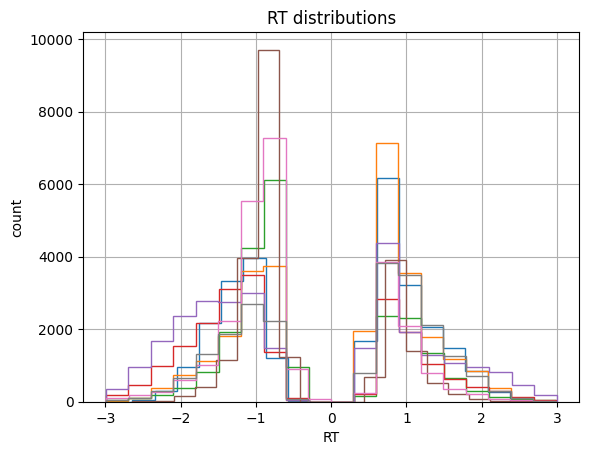

In [8]:
#check RT distributions

fig = plt.figure()
ax = fig.add_subplot(111, xlabel='RT', ylabel='count', title='RT distributions')
#ax.set_xlim([-1, 1])
#ax.set_ylim([0, 150])
for i, subj_data in data_all.groupby('subj_idx'):
    subj_data.rt.hist(bins=20, histtype='step', ax=ax)

In [9]:
data_subset = data_all[data_all['is_shared1000'] == 1]
data_subset = data_subset[data_subset['recall_condition'].isin(['new', 'hard'])]
data_subset = data_subset[data_subset['shared1000_repNum'].isin([2,3])]

In [10]:
trial_counts = data_subset.groupby('subj_idx').size().reset_index(name='n_trials')
trial_counts

,subj_idx,n_trials
0,1,1191
1,2,1252
2,3,830
3,4,723
4,5,1190
5,6,894
6,7,1114
7,8,790


In [11]:
data_subset.head(10)

,subj_idx,SESSION,RUN,TRIAL,X73KID,ISOLD,ISCORRECT,rt,CHANGEMIND,MEMORYRECENT,...,Beta_BA35,Beta_BA36,Beta_SUB,Beta_CA1,Beta_CA2,Beta_CA3,Beta_DG,Beta_PHC,Beta_HT,result
786,1,2,1,49,5603,1,1,1.804009,0,565.0,...,0.408548,0.148758,0.362248,0.217893,0.371569,0.122292,0.357703,1.079910,0.039344,HIT
787,1,2,1,50,3627,1,1,1.167157,0,224.0,...,0.382586,0.341549,0.381019,0.189091,0.445294,0.246562,0.685262,0.937707,0.067122,HIT
809,1,2,2,9,4787,1,1,1.235788,0,131.0,...,0.716279,0.383850,0.601190,0.151433,0.295294,1.060833,0.744948,1.178537,0.301044,HIT
831,1,2,2,33,14529,1,1,0.909421,0,120.0,...,0.049931,-0.178512,-0.230171,-0.162548,-0.111961,-0.882292,-0.382375,-0.151674,-0.176854,HIT
1052,1,2,6,8,38818,1,1,0.843925,0,550.0,...,0.715823,0.147735,-0.162638,-0.428182,0.374902,0.295938,0.086286,1.215716,-0.411834,HIT
1534,1,3,2,1,42300,1,1,1.544078,0,101.0,...,0.437275,-0.207244,0.192457,0.214242,0.460784,0.729375,0.503845,1.183529,0.263842,HIT
1545,1,3,2,12,62961,1,1,1.162291,0,74.0,...,0.685947,0.563364,0.159600,0.232810,-0.208431,0.321042,0.235617,0.521146,-0.212503,HIT
1563,1,3,2,30,7208,1,0,-2.117484,0,245.0,...,0.592739,0.370941,0.289657,0.068733,0.118627,0.353854,0.125919,0.771192,0.233226,MISS
1566,1,3,2,33,9435,1,1,1.617612,0,104.0,...,-0.529627,0.165706,-0.258038,-0.047424,-0.359020,-0.245104,-0.289423,-0.285882,0.008046,HIT
1619,1,3,3,25,8110,1,1,1.057941,0,452.0,...,-0.294357,0.779151,-0.123286,0.224435,-0.366863,-0.028125,-0.055551,0.336561,-0.287108,HIT


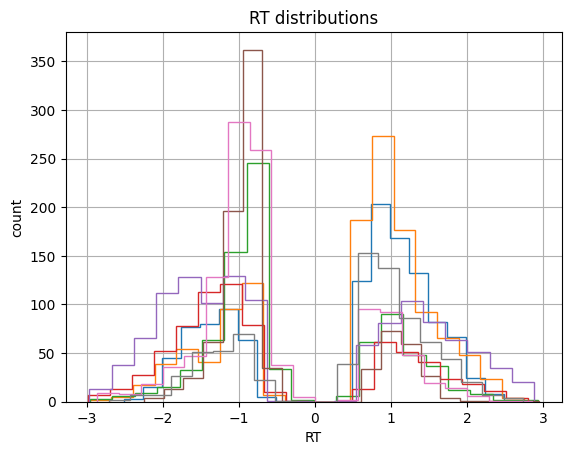

In [12]:
#check RT distributions

fig = plt.figure()
ax = fig.add_subplot(111, xlabel='RT', ylabel='count', title='RT distributions')
#ax.set_xlim([-1, 1])
#ax.set_ylim([0, 150])
for i, subj_data in data_subset.groupby('subj_idx'):
    subj_data.rt.hist(bins=20, histtype='step', ax=ax)

In [26]:
m_subset_van = hddm.HDDM(data_subset, bias=True, include=('v','a','z','t'), p_outlier=.05)
m_subset_van.find_starting_values()
m_subset_van.sample(2000, burn=500)

No model attribute --> setting up standard HDDM
Set model to ddm


/srv/conda/envs/notebook/lib/python3.8/site-packages/scipy/optimize/_optimize.py:2417: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 [-----------------100%-----------------] 2000 of 2000 complete in 133.4 sec

In [27]:
m_subset_van.print_stats()

              mean       std      2.5q       25q       50q       75q     97.5q    mc err
a         1.729722  0.078984   1.58067  1.679919  1.730088  1.777127  1.892631  0.001912
a_std     0.221593  0.075909  0.123434   0.16854  0.203784  0.256741  0.410936  0.003074
a_subj.1  1.787399  0.026291  1.738823  1.769723  1.787208  1.804738  1.841096  0.000726
a_subj.2  1.755386  0.024074  1.709588  1.739234  1.755243  1.771857  1.802317  0.000781
a_subj.3  1.583898   0.03165  1.523631  1.561258  1.583595  1.604633  1.645648  0.001465
a_subj.4  1.805378  0.036048  1.736786  1.780089  1.805337  1.829072  1.879439  0.001535
a_subj.5  1.999152  0.029204  1.945149  1.979206  1.998179  2.018357  2.057544  0.000978
a_subj.6  1.416834  0.024927  1.367823  1.399352  1.416417  1.434116  1.467124  0.000762
a_subj.7  1.622558  0.026466  1.572085  1.604882  1.622515  1.639354  1.673935  0.000953
a_subj.8  1.819759  0.033679  1.755745  1.797007  1.818954  1.842733  1.885392  0.001174
v          -0.2156  0

In [28]:
stats = m_subset_van.gen_stats()
stats[stats.index.isin(['a', 'a_std', 'a_subj.1', 'a_subj.2'])]

,mean,std,2.5q,25q,50q,75q,97.5q,mc err
a,1.729722,0.078984,1.58067,1.679919,1.730088,1.777127,1.892631,0.001912
a_std,0.221593,0.075909,0.123434,0.16854,0.203784,0.256741,0.410936,0.003074
a_subj.1,1.787399,0.026291,1.738823,1.769723,1.787208,1.804738,1.841096,0.000726
a_subj.2,1.755386,0.024074,1.709588,1.739234,1.755243,1.771857,1.802317,0.000781


Plotting a
Plotting v
Plotting t
Plotting z


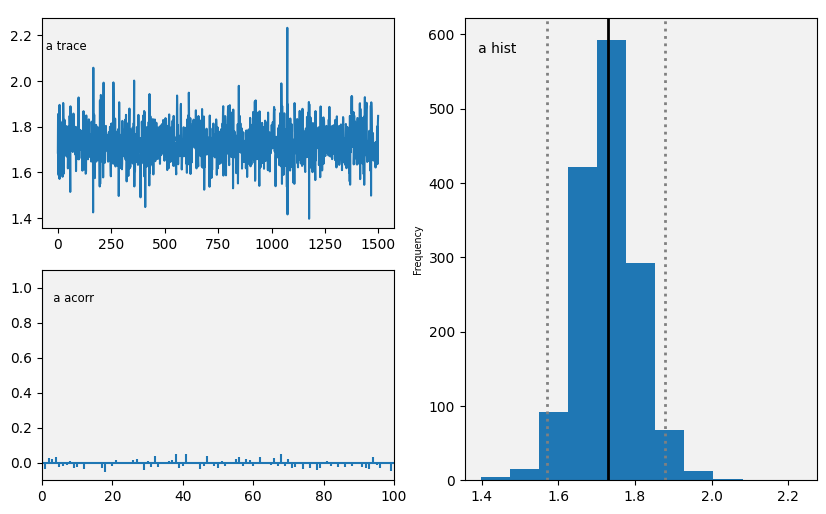

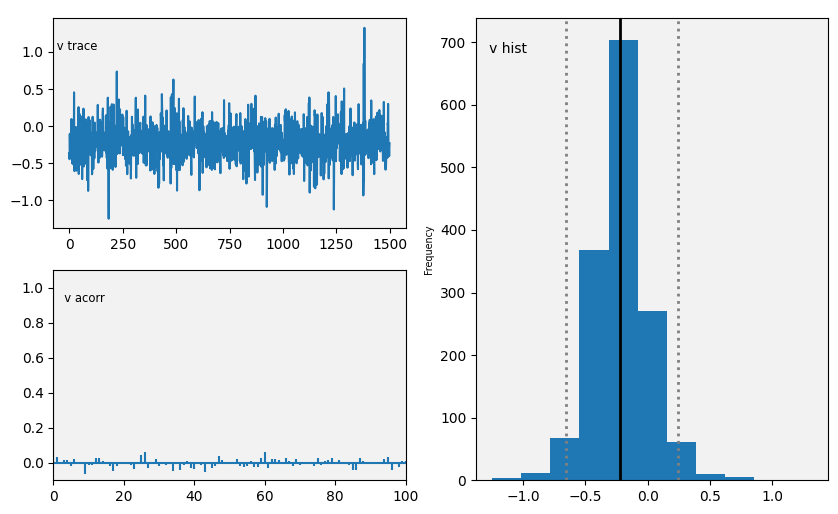

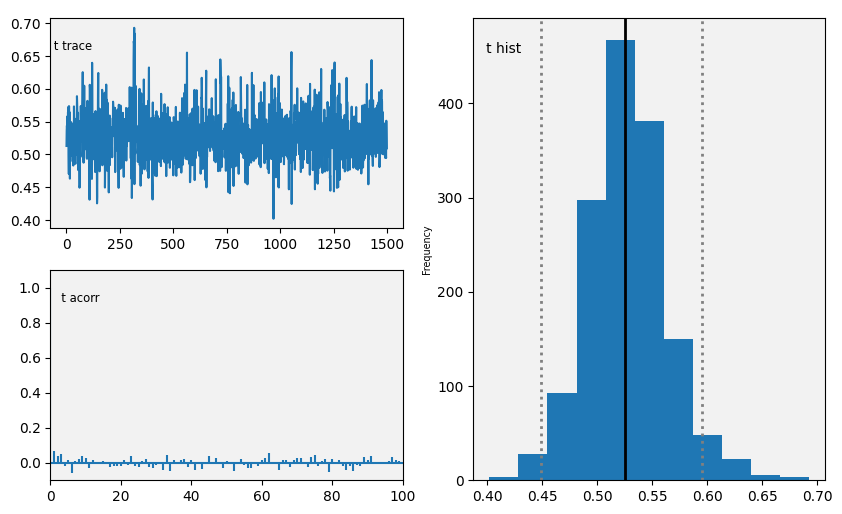

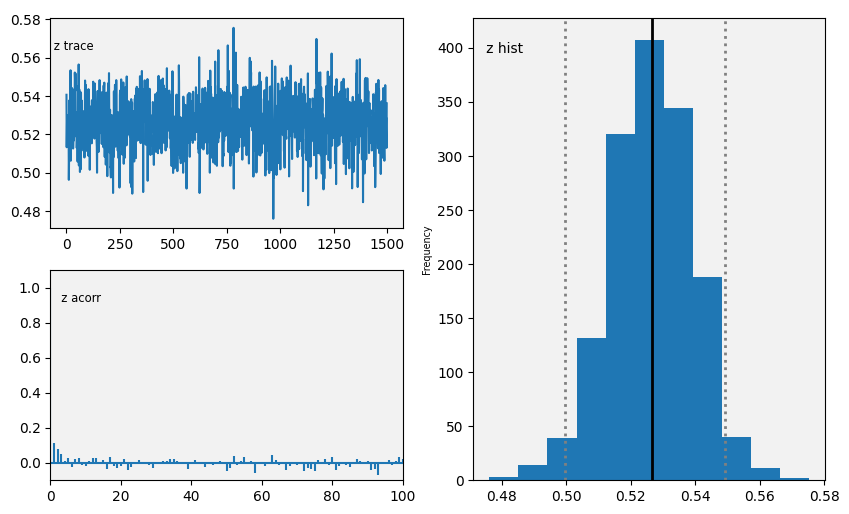

In [29]:
m_subset_van.plot_posteriors(['a', 't', 'v', 'z'])

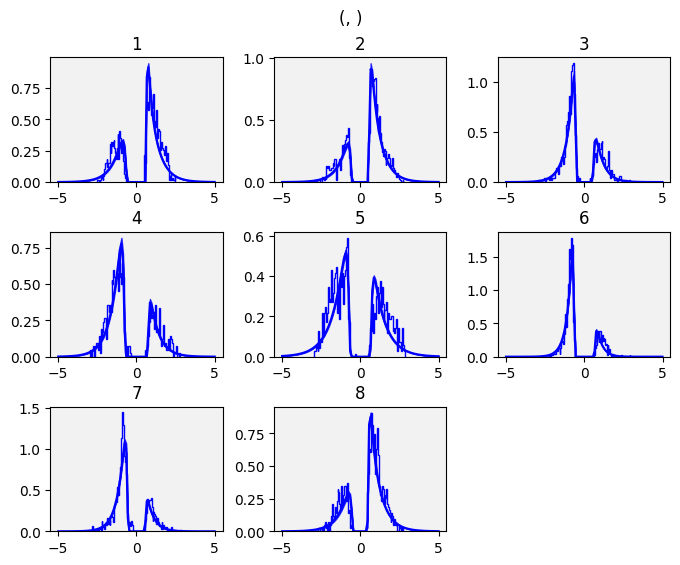

In [30]:
m_subset_van.plot_posterior_predictive()

In [31]:
#Gelman-Rubin statistic
#formal test for convergence; compares intra-chain variance to intra-chain variance of different runs of same model
# values should be close to 1, no larger than 1.02

models = []
for i in range(5):
    m = hddm.HDDM(data_subset,bias=True, include=('v','a','z','t'), p_outlier=.05)
    m.find_starting_values()
    m.sample(2000, burn=500)
    models.append(m)

hddm.analyze.gelman_rubin(models)

No model attribute --> setting up standard HDDM
Set model to ddm


/srv/conda/envs/notebook/lib/python3.8/site-packages/scipy/optimize/_optimize.py:2417: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 [-----------------100%-----------------] 2000 of 2000 complete in 132.7 secNo model attribute --> setting up standard HDDM
Set model to ddm


/srv/conda/envs/notebook/lib/python3.8/site-packages/scipy/optimize/_optimize.py:2417: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 [-----------------100%-----------------] 2001 of 2000 complete in 132.5 secNo model attribute --> setting up standard HDDM
Set model to ddm


/srv/conda/envs/notebook/lib/python3.8/site-packages/scipy/optimize/_optimize.py:2417: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 [-----------------100%-----------------] 2001 of 2000 complete in 134.1 secNo model attribute --> setting up standard HDDM
Set model to ddm


/srv/conda/envs/notebook/lib/python3.8/site-packages/scipy/optimize/_optimize.py:2417: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 [-----------------100%-----------------] 2001 of 2000 complete in 133.4 secNo model attribute --> setting up standard HDDM
Set model to ddm


/srv/conda/envs/notebook/lib/python3.8/site-packages/scipy/optimize/_optimize.py:2417: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 [-----------------100%-----------------] 2001 of 2000 complete in 133.6 sec

{'a': 1.0005460895246194,
 'a_std': 1.000263508872698,
 'a_subj.1': 1.0001673649746228,
 'a_subj.2': 1.0004503277866101,
 'a_subj.3': 1.0016858575777878,
 'a_subj.4': 1.0020863179713975,
 'a_subj.5': 1.0002366475164632,
 'a_subj.6': 1.000373777926019,
 'a_subj.7': 1.0003372871570895,
 'a_subj.8': 1.0010245860091609,
 'v': 0.9998822484218487,
 'v_std': 1.000850632451748,
 'v_subj.1': 1.0003702150209703,
 'v_subj.2': 1.000214482980237,
 'v_subj.3': 1.0016256237958678,
 'v_subj.4': 1.0007124864460608,
 'v_subj.5': 1.0013895793693783,
 'v_subj.6': 1.0020489263687948,
 'v_subj.7': 1.0010342176287272,
 'v_subj.8': 1.0004986924403527,
 't': 1.0001583666754514,
 't_std': 1.0007981162157022,
 't_subj.1': 1.0020055676041193,
 't_subj.2': 1.0016693625185233,
 't_subj.3': 1.0022009005324348,
 't_subj.4': 1.0018077982978177,
 't_subj.5': 1.0003435526477773,
 't_subj.6': 1.0012662639128675,
 't_subj.7': 1.0004295819540239,
 't_subj.8': 1.0011672943107357,
 'z_trans': 1.0001474194746227,
 'z_std': 1.

#### group-level model with mean mtl beta

In [13]:
m_subset_mtl2 = hddm.HDDMRegressor(data_subset, ["a ~ MTL_ROI_Beta:C(shared1000_repNum, Treatment('2'))", "v ~ MTL_ROI_Beta:C(shared1000_repNum, Treatment('2'))", "z ~ MTL_ROI_Beta:C(shared1000_repNum, Treatment('2'))", "t ~ MTL_ROI_Beta:C(shared1000_repNum, Treatment('2'))"], include=('v','a','z','t'), group_only_regressors=True, p_outlier=.05)
m_subset_mtl2.sample(2000, burn=500)

No model attribute --> setting up standard HDDM
Set model to ddm
 [-----------------100%-----------------] 2001 of 2000 complete in 1975.4 sec

In [14]:
m_subset_mtl2.print_stats()

                                                            mean       std      2.5q       25q       50q       75q     97.5q    mc err
a_Intercept                                             1.724167  0.093347  1.542454   1.66875   1.72236  1.776887  1.913122  0.002995
a_Intercept_std                                         0.237832  0.087643  0.130559  0.178148  0.218514  0.275826  0.454358  0.003917
a_Intercept_subj.1                                      1.807547   0.04442  1.734221  1.772193  1.801231  1.844287  1.891427  0.003589
a_Intercept_subj.2                                      1.742002   0.02746  1.687437  1.723603  1.741853   1.76058  1.794449  0.001177
a_Intercept_subj.3                                       1.57267  0.032485  1.510352  1.550424  1.572636  1.594479  1.636447   0.00149
a_Intercept_subj.4                                      1.825317  0.040807  1.743126  1.796977  1.826228  1.854093  1.905425  0.002252
a_Intercept_subj.5                                     

Plotting a_Intercept
Plotting a_MTL_ROI_Beta:C(shared1000_repNum, Treatment('2'))[2]
Plotting a_MTL_ROI_Beta:C(shared1000_repNum, Treatment('2'))[3]


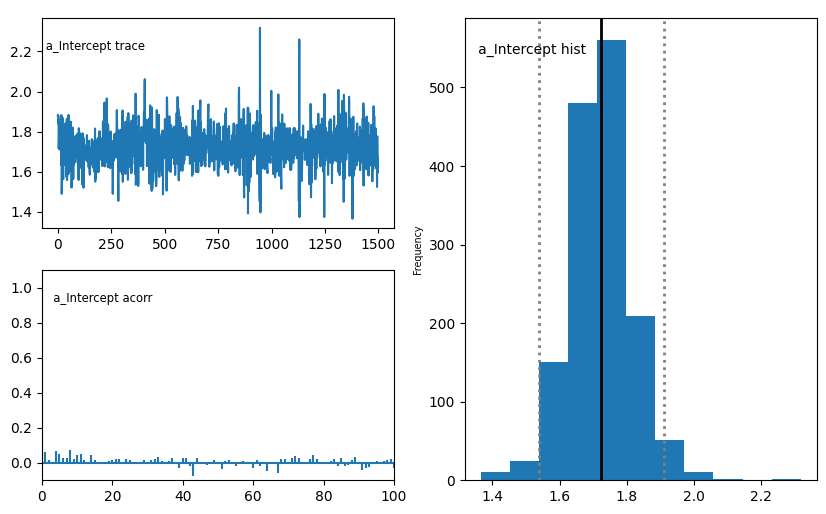

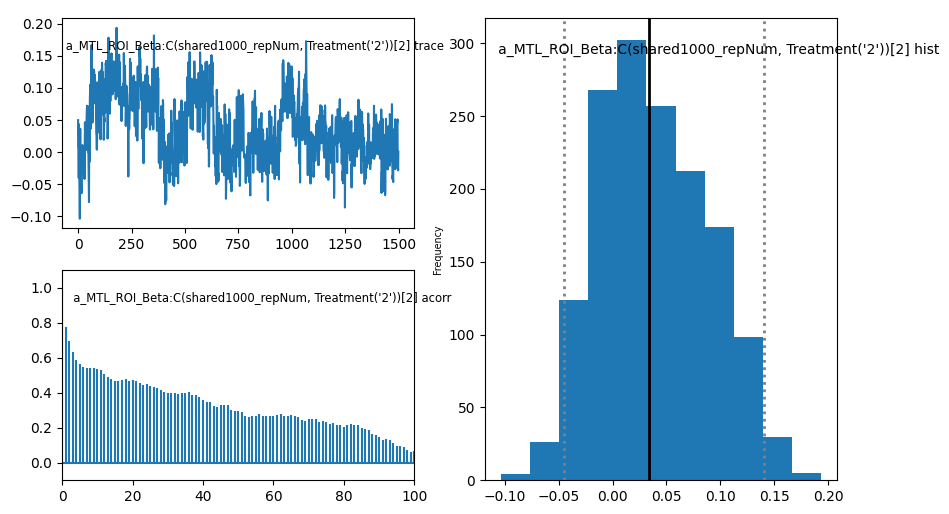

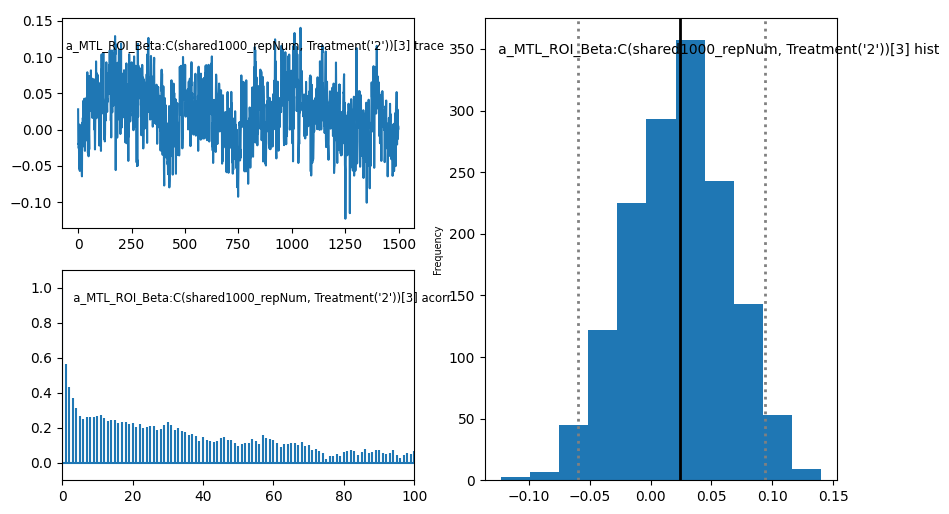

In [15]:
m_subset_mtl2.plot_posteriors(["a_Intercept","a_MTL_ROI_Beta:C(shared1000_repNum, Treatment('2'))[2]", "a_MTL_ROI_Beta:C(shared1000_repNum, Treatment('2'))[3]"])

Plotting v_Intercept
Plotting v_MTL_ROI_Beta:C(shared1000_repNum, Treatment('2'))[2]
Plotting v_MTL_ROI_Beta:C(shared1000_repNum, Treatment('2'))[3]


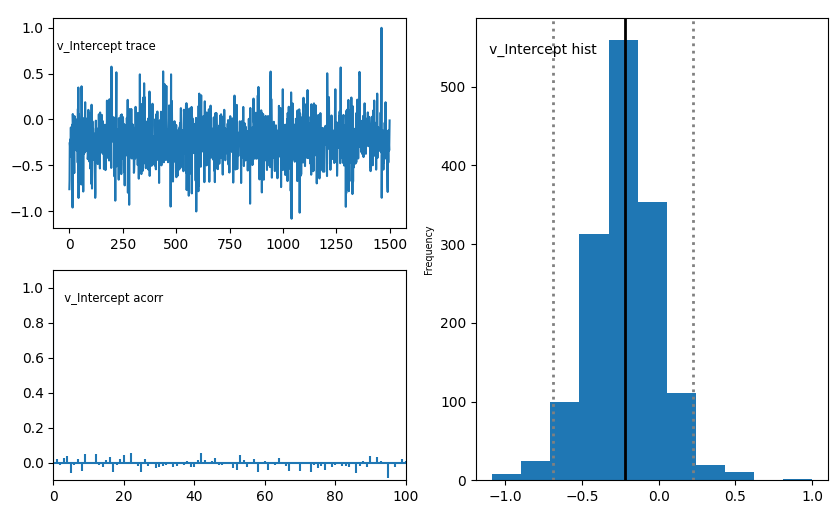

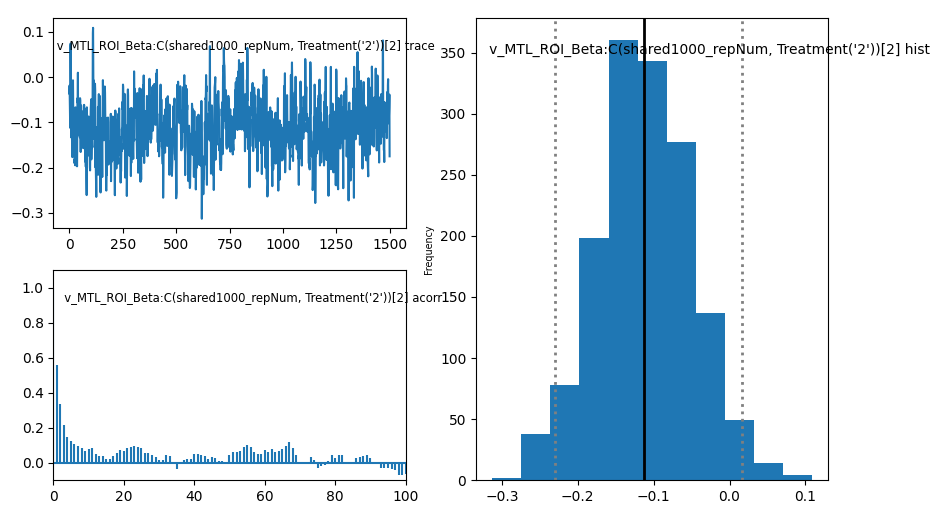

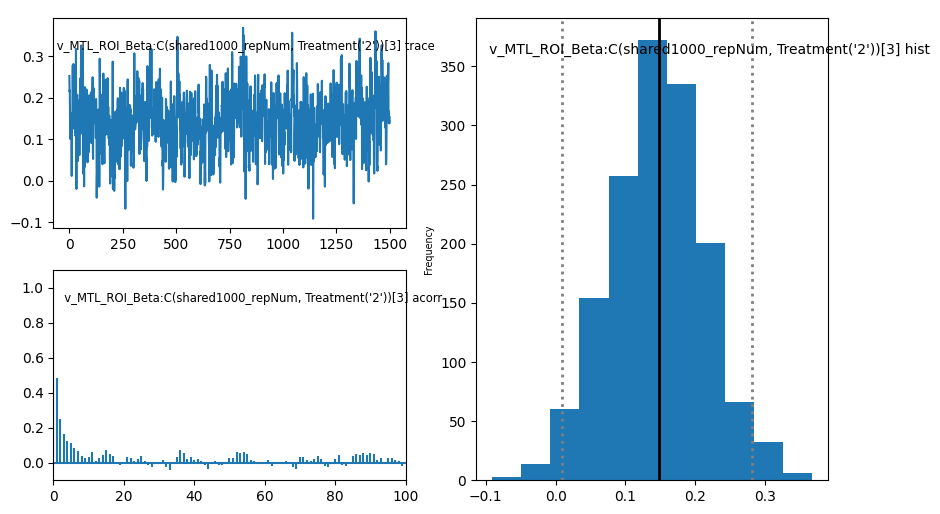

In [17]:
m_subset_mtl2.plot_posteriors(["v_Intercept","v_MTL_ROI_Beta:C(shared1000_repNum, Treatment('2'))[2]", "v_MTL_ROI_Beta:C(shared1000_repNum, Treatment('2'))[3]"])

Plotting z_Intercept
Plotting z_MTL_ROI_Beta:C(shared1000_repNum, Treatment('2'))[2]
Plotting z_MTL_ROI_Beta:C(shared1000_repNum, Treatment('2'))[3]


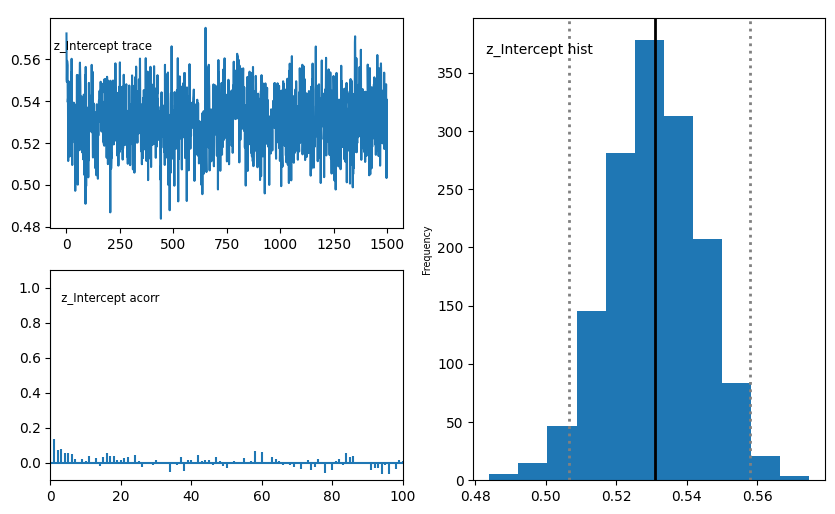

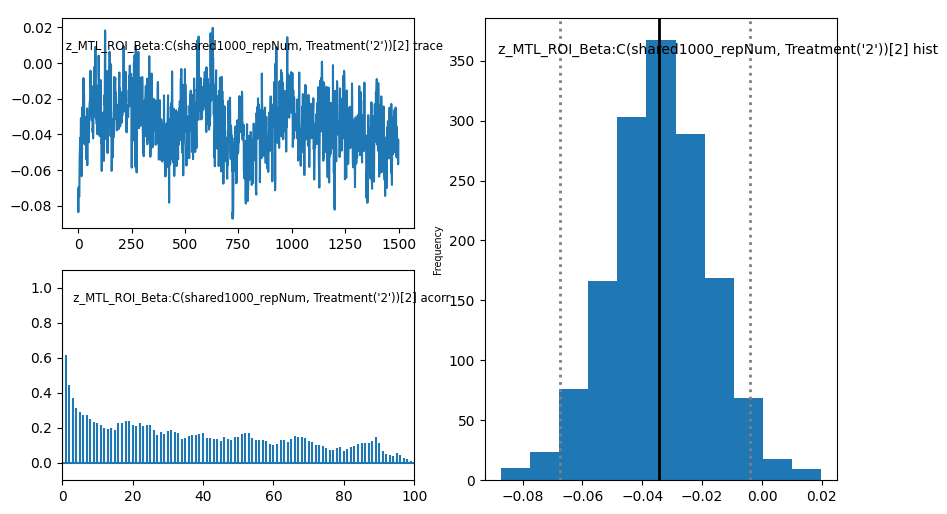

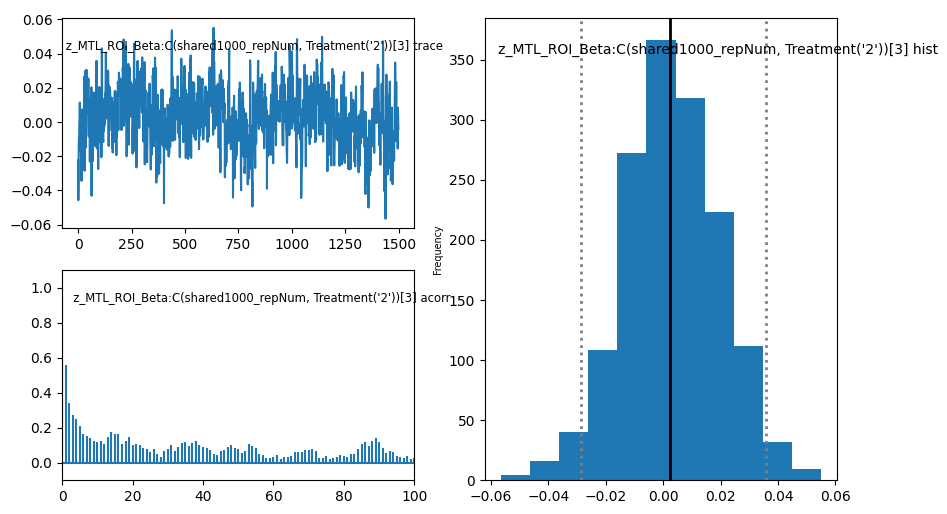

In [18]:
m_subset_mtl2.plot_posteriors(["z_Intercept","z_MTL_ROI_Beta:C(shared1000_repNum, Treatment('2'))[2]", "z_MTL_ROI_Beta:C(shared1000_repNum, Treatment('2'))[3]"])

P(a_MTLbeta > 0) =  0.752


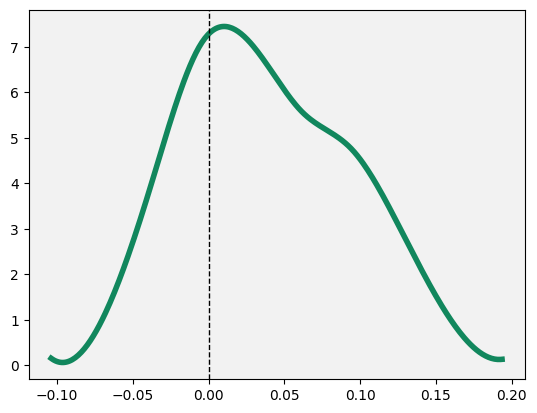

In [20]:
mtl_beta = m_subset_mtl2.nodes_db.node["a_MTL_ROI_Beta:C(shared1000_repNum, Treatment('2'))[2]"]
hddm.analyze.plot_posterior_nodes([mtl_beta], bins=10)

plt.rcParams['axes.facecolor'] = '0.95'
plt.gca().get_lines()[0].set_color("xkcd:dark sea green")
ax=plt.gca()
lines0= ax.get_lines()[0]
plt.setp(lines0, linestyle='-', linewidth=4)
plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
plt.legend().remove()

print("P(a_MTLbeta > 0) = ", (mtl_beta.trace() > 0).mean())

P(a_MTLbeta > 0) =  0.708


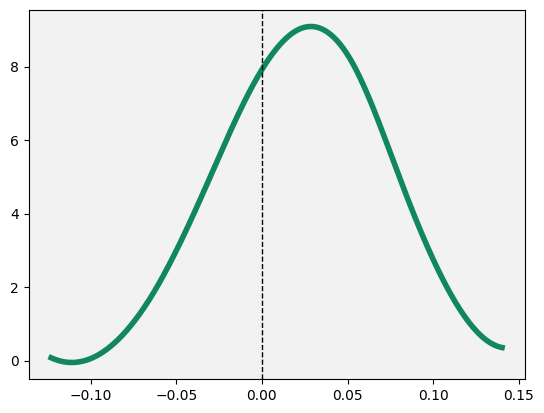

In [21]:
mtl_beta = m_subset_mtl2.nodes_db.node["a_MTL_ROI_Beta:C(shared1000_repNum, Treatment('2'))[3]"]
hddm.analyze.plot_posterior_nodes([mtl_beta], bins=10)

plt.rcParams['axes.facecolor'] = '0.95'
plt.gca().get_lines()[0].set_color("xkcd:dark sea green")
ax=plt.gca()
lines0= ax.get_lines()[0]
plt.setp(lines0, linestyle='-', linewidth=4)
plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
plt.legend().remove()

print("P(a_MTLbeta > 0) = ", (mtl_beta.trace() > 0).mean())

P(v_MTLbeta > 0) =  0.037333333333333336


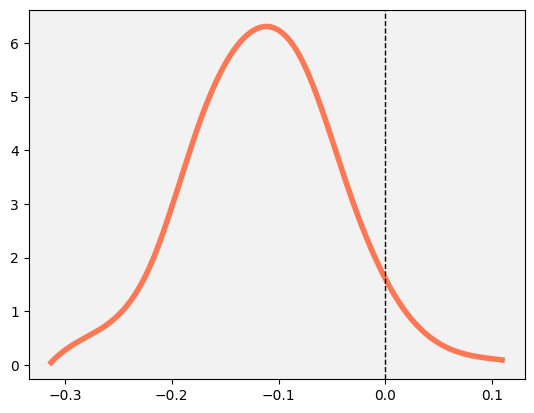

In [22]:
mtl_beta = m_subset_mtl2.nodes_db.node["v_MTL_ROI_Beta:C(shared1000_repNum, Treatment('2'))[2]"]
hddm.analyze.plot_posterior_nodes([mtl_beta], bins=10)

plt.rcParams['axes.facecolor'] = '0.95'
plt.gca().get_lines()[0].set_color("xkcd:melon")
ax=plt.gca()
lines0= ax.get_lines()[0]
plt.setp(lines0, linestyle='-', linewidth=4)
plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
plt.legend().remove()

print("P(v_MTLbeta > 0) = ", (mtl_beta.trace() > 0).mean())

P(v_MTLbeta > 0) =  0.9826666666666667


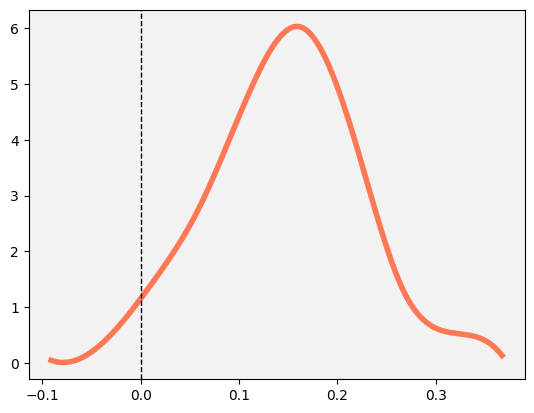

In [23]:
mtl_beta = m_subset_mtl2.nodes_db.node["v_MTL_ROI_Beta:C(shared1000_repNum, Treatment('2'))[3]"]
hddm.analyze.plot_posterior_nodes([mtl_beta], bins=10)

plt.rcParams['axes.facecolor'] = '0.95'
plt.gca().get_lines()[0].set_color("xkcd:melon")
ax=plt.gca()
lines0= ax.get_lines()[0]
plt.setp(lines0, linestyle='-', linewidth=4)
plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
plt.legend().remove()

print("P(v_MTLbeta > 0) = ", (mtl_beta.trace() > 0).mean())

P(z_MTLbeta > 0) =  0.018


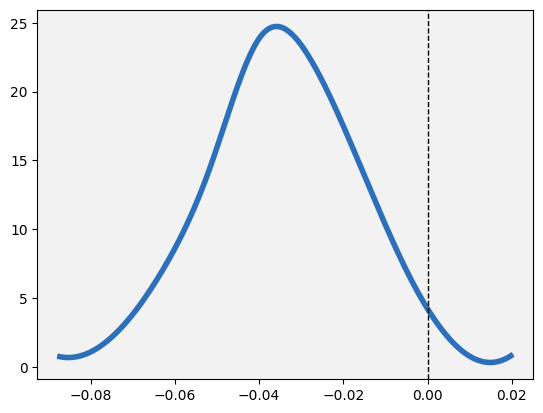

In [24]:
mtl_beta = m_subset_mtl2.nodes_db.node["z_MTL_ROI_Beta:C(shared1000_repNum, Treatment('2'))[2]"]
hddm.analyze.plot_posterior_nodes([mtl_beta], bins=10)

plt.rcParams['axes.facecolor'] = '0.95'
plt.gca().get_lines()[0].set_color("xkcd:medium blue")
ax=plt.gca()
lines0= ax.get_lines()[0]
plt.setp(lines0, linestyle='-', linewidth=4)
plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
plt.legend().remove()

print("P(z_MTLbeta > 0) = ", (mtl_beta.trace() > 0).mean())

#### group-level model with phc beta

In [43]:
m_subset_phc2 = hddm.HDDMRegressor(data_subset, ["a ~ Beta_PHC:C(shared1000_repNum, Treatment('2'))", "v ~ Beta_PHC:C(shared1000_repNum, Treatment('2'))", "z ~ Beta_PHC:C(shared1000_repNum, Treatment('2'))", "t ~ Beta_PHC:C(shared1000_repNum, Treatment('2'))"], include=('v','a','z','t'), group_only_regressors=True, p_outlier=.05)
m_subset_phc2.sample(2000, burn=500)

No model attribute --> setting up standard HDDM
Set model to ddm
 [-----------------100%-----------------] 2001 of 2000 complete in 1919.2 sec

In [44]:
m_subset_phc2.print_stats()

                                                        mean       std      2.5q       25q       50q       75q     97.5q    mc err
a_Intercept                                         1.673576  0.074258  1.525454  1.626521  1.670675  1.719337  1.824353  0.002218
a_Intercept_std                                     0.207911  0.069486  0.113612  0.158046  0.194224  0.242501  0.387443  0.002728
a_Intercept_subj.1                                   1.76575  0.043774  1.692819  1.732789  1.761032  1.798559  1.853204  0.003146
a_Intercept_subj.2                                  1.677311   0.02754  1.623211  1.658817  1.676635  1.696028  1.731307  0.001226
a_Intercept_subj.3                                  1.548139  0.031143  1.486517    1.5268  1.547471  1.569057  1.611314   0.00112
a_Intercept_subj.4                                  1.790334   0.03978  1.705289  1.765025   1.79242  1.817305  1.863628  0.001929
a_Intercept_subj.5                                  1.887563  0.034507  1.818118  1

Plotting a_Intercept
Plotting a_Beta_PHC:C(shared1000_repNum, Treatment('2'))[2]
Plotting a_Beta_PHC:C(shared1000_repNum, Treatment('2'))[3]


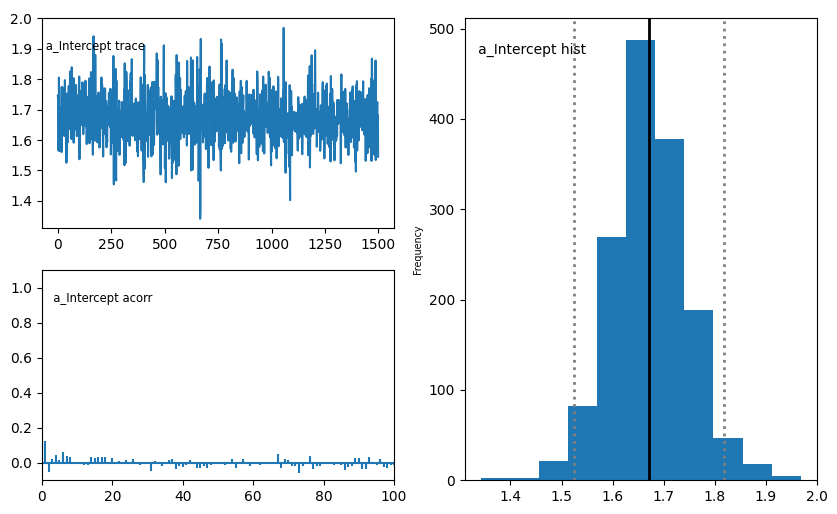

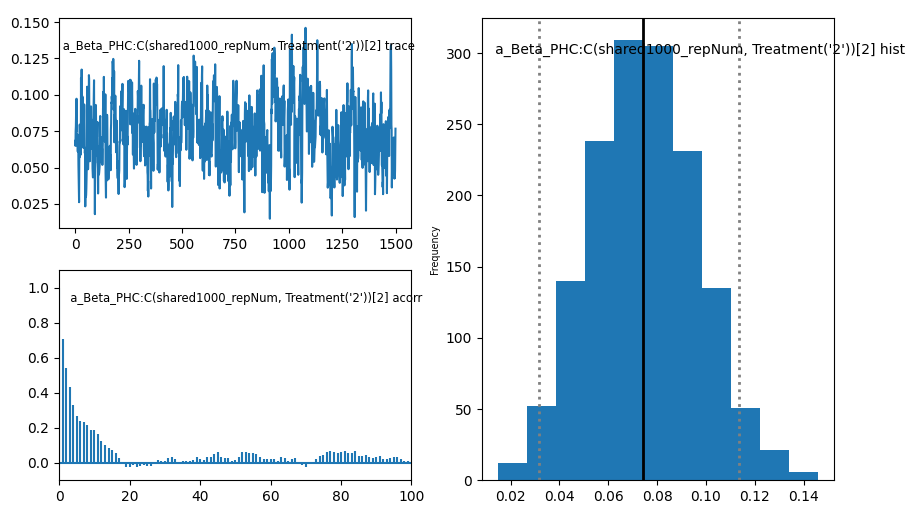

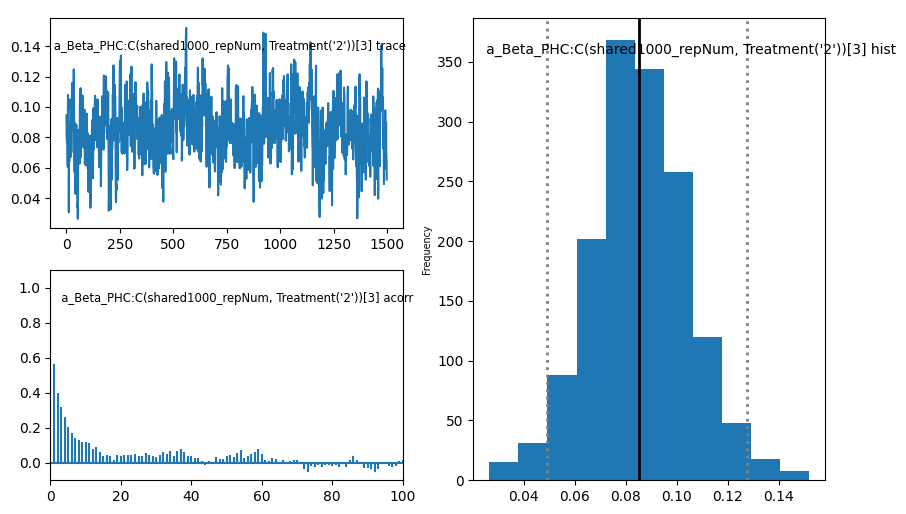

In [45]:
m_subset_phc2.plot_posteriors(["a_Intercept","a_Beta_PHC:C(shared1000_repNum, Treatment('2'))[2]", "a_Beta_PHC:C(shared1000_repNum, Treatment('2'))[3]"])

Plotting v_Intercept
Plotting v_Beta_PHC:C(shared1000_repNum, Treatment('2'))[2]
Plotting v_Beta_PHC:C(shared1000_repNum, Treatment('2'))[3]


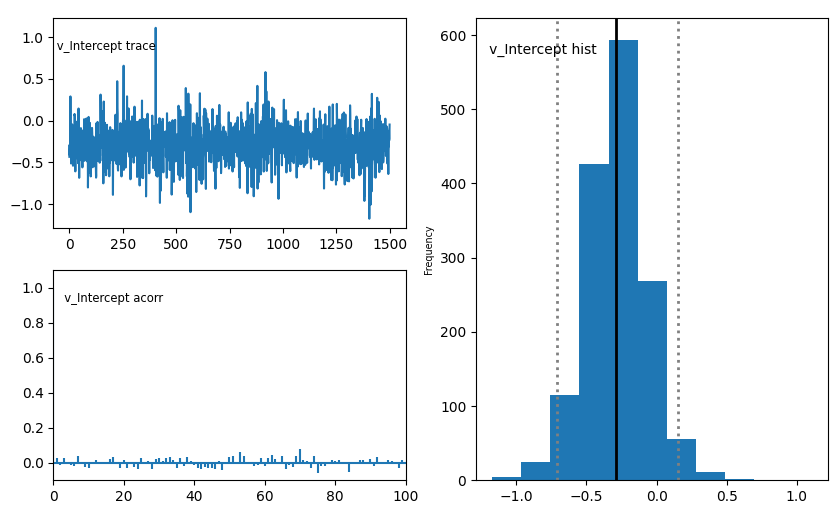

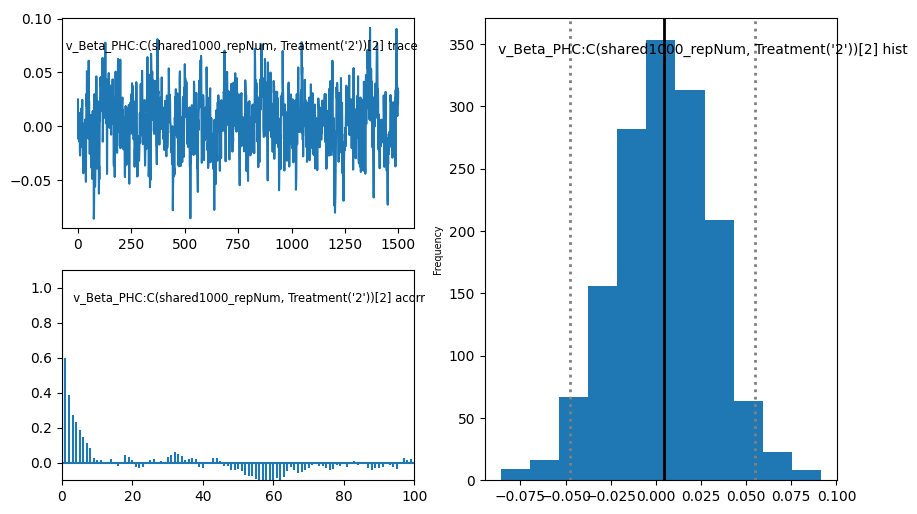

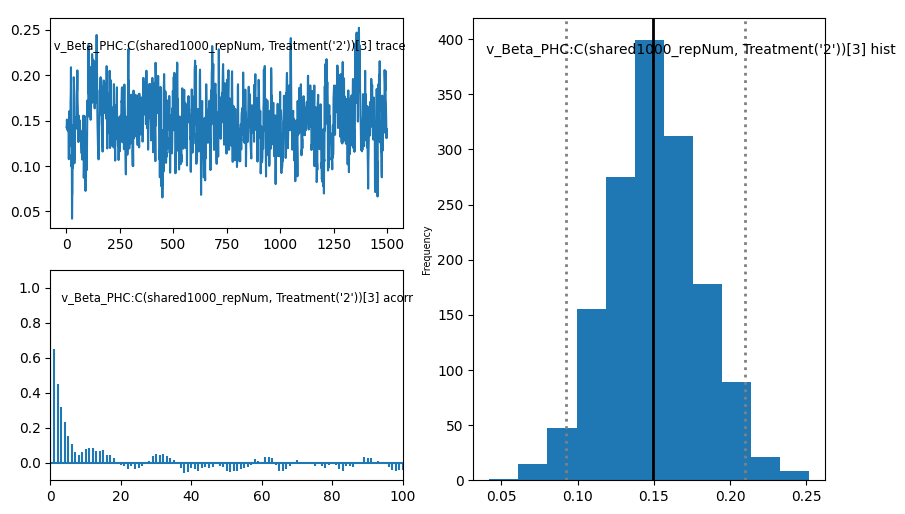

In [46]:
m_subset_phc2.plot_posteriors(["v_Intercept","v_Beta_PHC:C(shared1000_repNum, Treatment('2'))[2]", "v_Beta_PHC:C(shared1000_repNum, Treatment('2'))[3]"])

Plotting z_Intercept
Plotting z_Beta_PHC:C(shared1000_repNum, Treatment('2'))[2]
Plotting z_Beta_PHC:C(shared1000_repNum, Treatment('2'))[3]


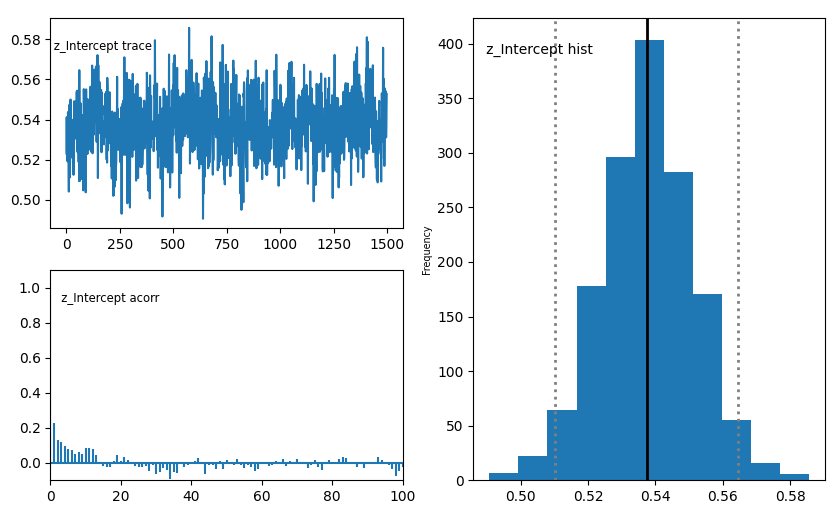

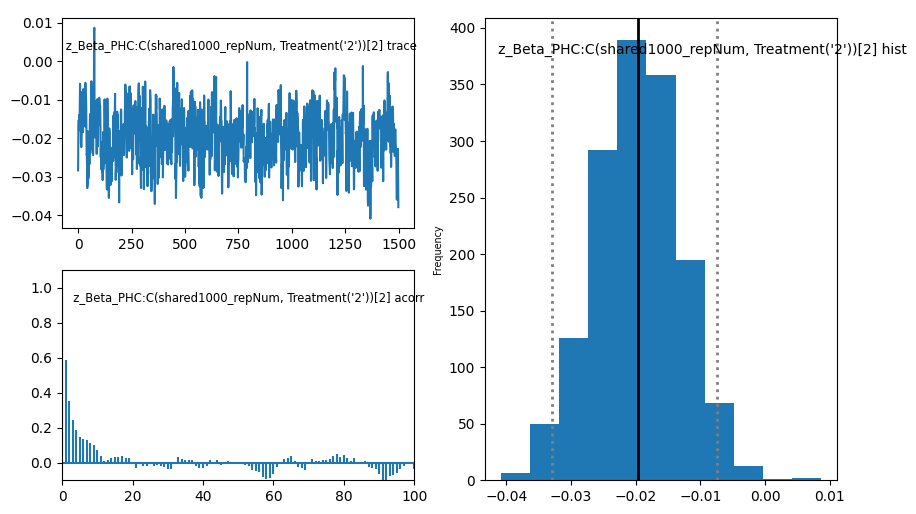

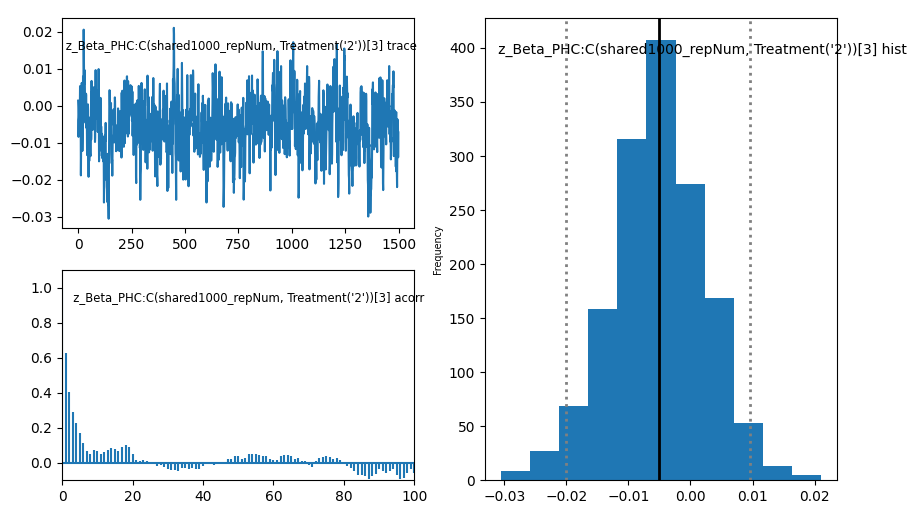

In [47]:
m_subset_phc2.plot_posteriors(["z_Intercept","z_Beta_PHC:C(shared1000_repNum, Treatment('2'))[2]", "z_Beta_PHC:C(shared1000_repNum, Treatment('2'))[3]"])

Plotting t_Intercept
Plotting t_Beta_PHC:C(shared1000_repNum, Treatment('2'))[2]
Plotting t_Beta_PHC:C(shared1000_repNum, Treatment('2'))[3]


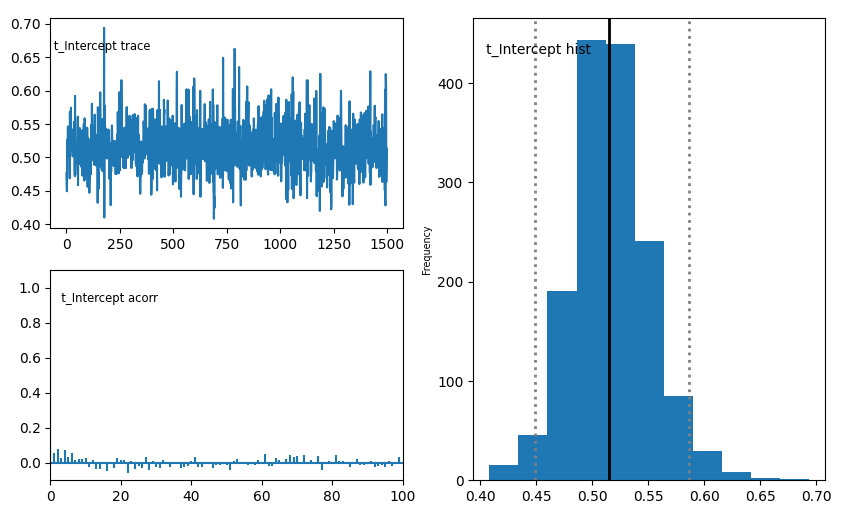

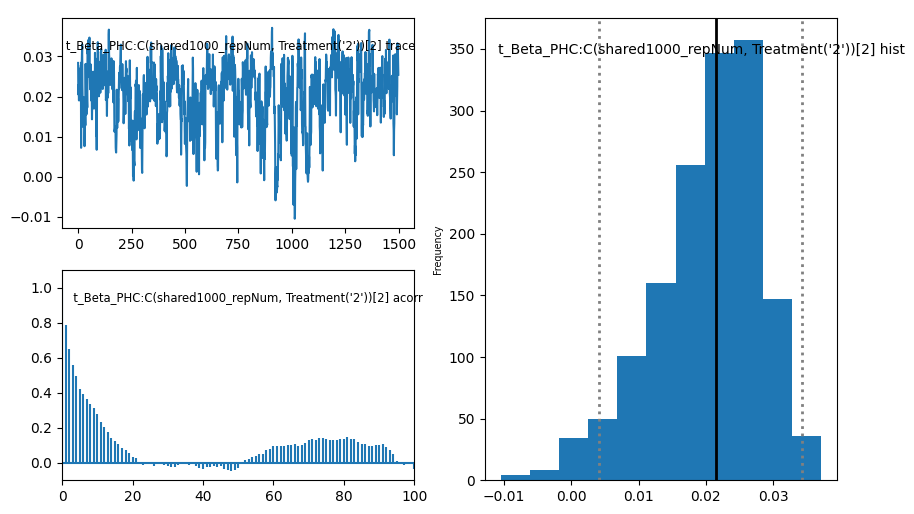

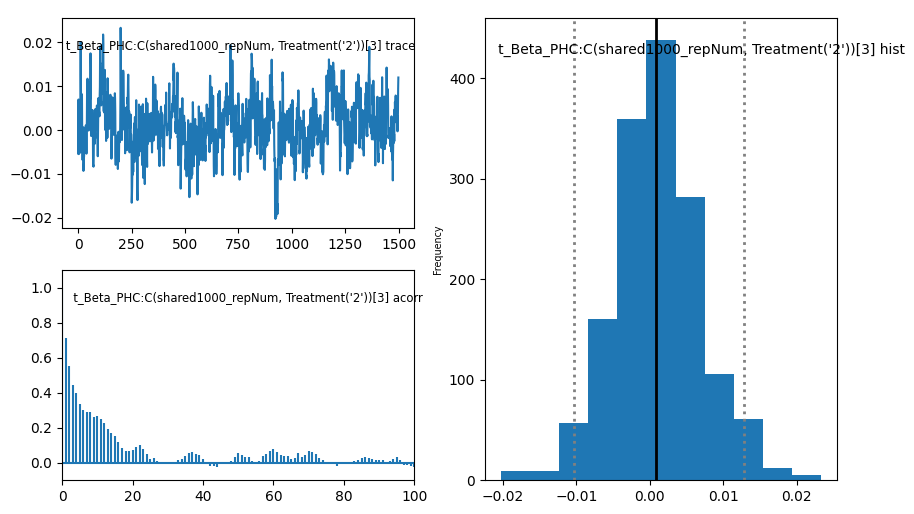

In [48]:
m_subset_phc2.plot_posteriors(["t_Intercept","t_Beta_PHC:C(shared1000_repNum, Treatment('2'))[2]", "t_Beta_PHC:C(shared1000_repNum, Treatment('2'))[3]"])

P(a_PHCbeta > 0) =  1.0


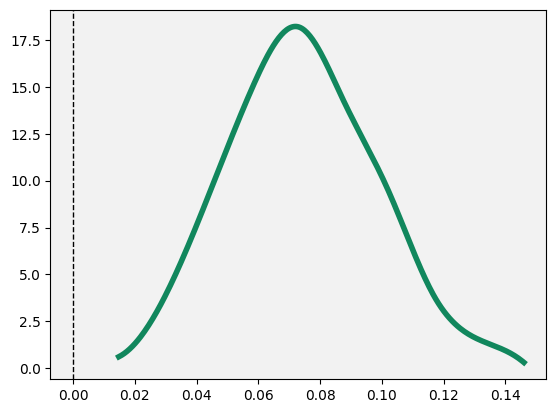

In [61]:
phc_beta = m_subset_phc2.nodes_db.node["a_Beta_PHC:C(shared1000_repNum, Treatment('2'))[2]"]
hddm.analyze.plot_posterior_nodes([phc_beta], bins=10)

plt.rcParams['axes.facecolor'] = '0.95'
plt.gca().get_lines()[0].set_color("xkcd:dark sea green")
ax=plt.gca()
lines0= ax.get_lines()[0]
plt.setp(lines0, linestyle='-', linewidth=4)
plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
plt.legend().remove()

print("P(a_PHCbeta > 0) = ", (phc_beta.trace() > 0).mean())

P(a_PHCbeta > 0) =  1.0


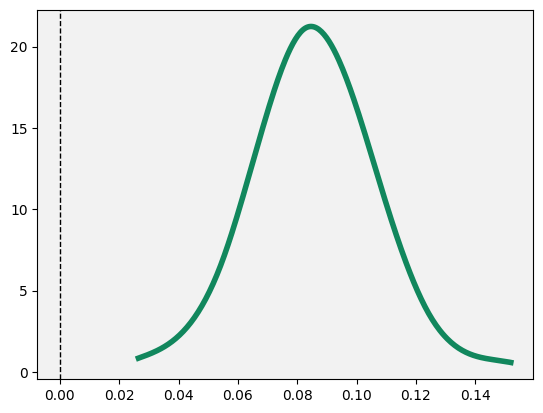

In [62]:
phc_beta = m_subset_phc2.nodes_db.node["a_Beta_PHC:C(shared1000_repNum, Treatment('2'))[3]"]
hddm.analyze.plot_posterior_nodes([phc_beta], bins=10)

plt.rcParams['axes.facecolor'] = '0.95'
plt.gca().get_lines()[0].set_color("xkcd:dark sea green")
ax=plt.gca()
lines0= ax.get_lines()[0]
plt.setp(lines0, linestyle='-', linewidth=4)
plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
plt.legend().remove()

print("P(a_PHCbeta > 0) = ", (phc_beta.trace() > 0).mean())

P(v_PHCbeta > 0) =  0.5666666666666667


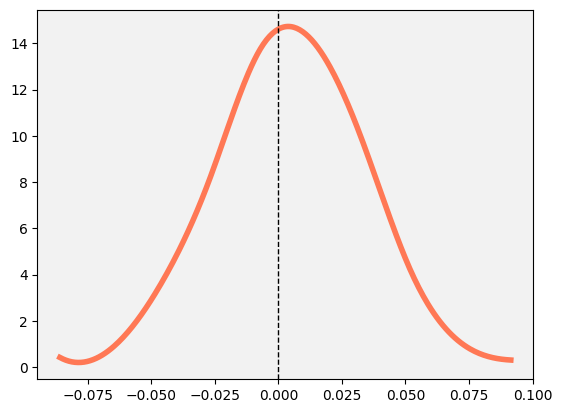

In [63]:
phc_beta = m_subset_phc2.nodes_db.node["v_Beta_PHC:C(shared1000_repNum, Treatment('2'))[2]"]
hddm.analyze.plot_posterior_nodes([phc_beta], bins=10)

plt.rcParams['axes.facecolor'] = '0.95'
plt.gca().get_lines()[0].set_color("xkcd:melon")
ax=plt.gca()
lines0= ax.get_lines()[0]
plt.setp(lines0, linestyle='-', linewidth=4)
plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
plt.legend().remove()

print("P(v_PHCbeta > 0) = ", (phc_beta.trace() > 0).mean())

P(v_PHCbeta > 0) =  1.0


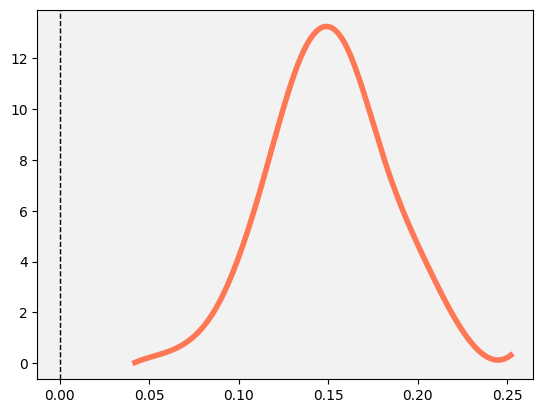

In [64]:
phc_beta = m_subset_phc2.nodes_db.node["v_Beta_PHC:C(shared1000_repNum, Treatment('2'))[3]"]
hddm.analyze.plot_posterior_nodes([phc_beta], bins=10)

plt.rcParams['axes.facecolor'] = '0.95'
plt.gca().get_lines()[0].set_color("xkcd:melon")
ax=plt.gca()
lines0= ax.get_lines()[0]
plt.setp(lines0, linestyle='-', linewidth=4)
plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
plt.legend().remove()

print("P(v_PHCbeta > 0) = ", (phc_beta.trace() > 0).mean())

P(z_PHCbeta > 0) =  0.0013333333333333333


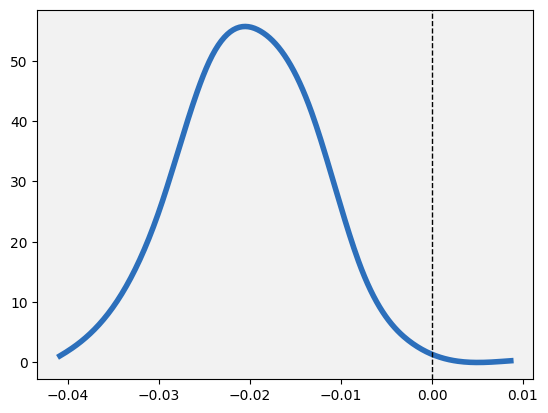

In [65]:
phc_beta = m_subset_phc2.nodes_db.node["z_Beta_PHC:C(shared1000_repNum, Treatment('2'))[2]"]
hddm.analyze.plot_posterior_nodes([phc_beta], bins=10)

plt.rcParams['axes.facecolor'] = '0.95'
plt.gca().get_lines()[0].set_color("xkcd:medium blue")
ax=plt.gca()
lines0= ax.get_lines()[0]
plt.setp(lines0, linestyle='-', linewidth=4)
plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
plt.legend().remove()

print("P(z_PHCbeta > 0) = ", (phc_beta.trace() > 0).mean())

P(z_PHCbeta > 0) =  0.24


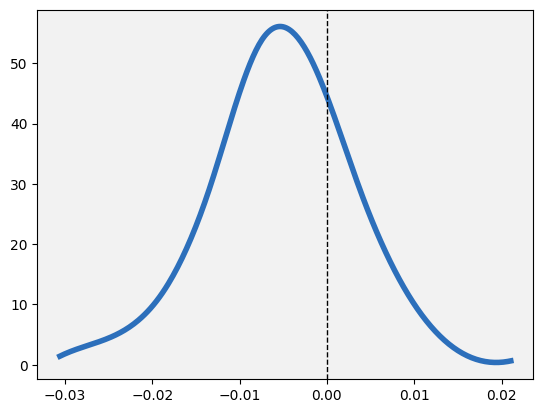

In [66]:
phc_beta = m_subset_phc2.nodes_db.node["z_Beta_PHC:C(shared1000_repNum, Treatment('2'))[3]"]
hddm.analyze.plot_posterior_nodes([phc_beta], bins=10)

plt.rcParams['axes.facecolor'] = '0.95'
plt.gca().get_lines()[0].set_color("xkcd:medium blue")
ax=plt.gca()
lines0= ax.get_lines()[0]
plt.setp(lines0, linestyle='-', linewidth=4)
plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
plt.legend().remove()

print("P(z_PHCbeta > 0) = ", (phc_beta.trace() > 0).mean())

P(t_PHCbeta > 0) =  0.986


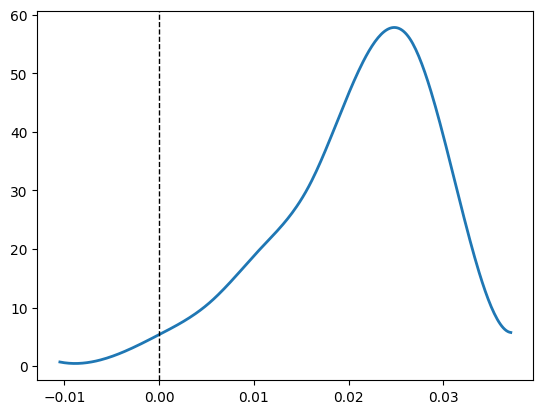

In [58]:
phc_beta = m_subset_phc2.nodes_db.node["t_Beta_PHC:C(shared1000_repNum, Treatment('2'))[2]"]
hddm.analyze.plot_posterior_nodes([phc_beta], bins=10)
plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
plt.legend().remove()

print("P(t_PHCbeta > 0) = ", (phc_beta.trace() > 0).mean())

P(t_PHCbeta > 0) =  0.5713333333333334


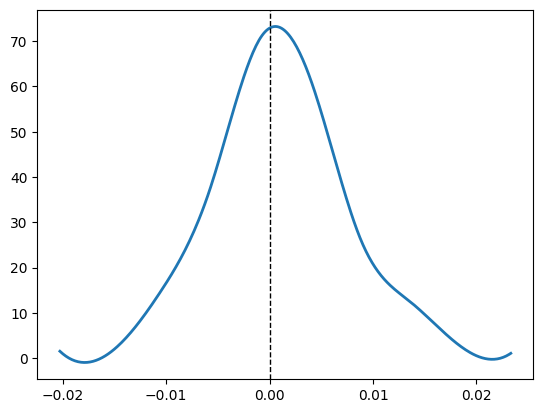

In [59]:
phc_beta = m_subset_phc2.nodes_db.node["t_Beta_PHC:C(shared1000_repNum, Treatment('2'))[3]"]
hddm.analyze.plot_posterior_nodes([phc_beta], bins=10)
plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
plt.legend().remove()

print("P(t_PHCbeta > 0) = ", (phc_beta.trace() > 0).mean())